<div class="alert alert-info" role="alert">
  <hr> <center> <font size="+3.5"> <b> Interpréter des conditions atypiques à l'aide d'autoencodeurs variationnels conditionnels </b> </font> </center> <hr>
</div>

<div class="alert alert-block" role="alert">
    <center><b> <u>Auteur :</u>  Clement GOUBET  </b></center>
</div>
<div class="alert alert-block" role="alert">
    <center> <font size="+1.5"> <b>  23 juillet 2019  </b>  </font> </center>
</div>

# Table de contenu

## 0. Préparation de l'environnement de travail
- chargement des modules
- mise en forme des données
- définition de quelques fonctions utiles

## 1. Premier modèle VAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations

## 2. Modèle CVAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations
- analyse spécifique jours fériés et points atypiques

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 0. Preparation de l'environnement de travail </b> </font> <hr>
</div>

# Chargement des modules et mise en forme des données

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images
from IPython.display import Image
from tensorflow.keras.callbacks import TensorBoard
from time import time
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
#root git folder 
name_model="vae_test"
path_second_folder = %pwd #"/home/goubetcle/Documents/Git/VAE/"
save_path = os.path.join(path_second_folder,"Results")#"/home/goubetcle/Documents/VAE/"
log_dir_model=os.path.join(save_path,"logs")
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_second_folder)

In [3]:
import importlib

sys.path.append(path_second_folder+'/src')

#import models, loss_class, params_class,AE_blocks,metrics
from src.models import *
#importlib.reload(models)
from src.loss_class import *
#importlib.reload(loss_class)
from src.params_class import *
#importlib.reload(params_class)
import src.AE_blocks
#importlib.reload(AE_blocks)
from src.metrics import *
#importlib.reload(metrics)
from src.utils import *


2021-12-21 11:19:25.419239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 11:19:25.454054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 11:19:25.454238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 11:19:25.454930: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Les données de consommation et de température sont des prises de mesure par pas de temps 30 minutes pendant 5 années de décembre 2012 à décembre 2020. 

In [5]:
# Load dataframe
dataset_csv = os.path.join('data', "dataset_2012_2020.csv")
df_data = pd.read_csv(dataset_csv, sep=";",)
df_data.utc_datetime = pd.to_datetime(df_data.utc_datetime, utc=True)

#Visualize data frame head
df_data.tail(5)

,ds,consumption_France,temperature_France,is_holiday_day,conso_final,day_ahead
87825,2017-12-31 21:30:00,56505.0,9.306475,0.0,56739.0,53500.0
87826,2017-12-31 22:00:00,56000.0,9.097250,0.0,56233.0,53000.0
87827,2017-12-31 22:30:00,56995.0,9.048775,0.0,57239.0,54700.0
87828,2017-12-31 23:00:00,60395.0,9.000300,0.0,60642.0,57300.0
87829,2017-12-31 23:30:00,60230.0,9.000300,0.0,60479.0,57300.0


On s'intéresse ici à caractériser les profils journaliers. L'ensemble de données est donc transformé pour que notre jeu d'entrée soit ait en colonnes les points de mesure journaliers de la consommation d'électricité. Avant cela, il est ici normalisé sur l'ensemble des mesures.

In [6]:
ds = pd.DataFrame({"days" : df_data.utc_datetime.dt.date, "minute":df_data.utc_datetime.dt.minute+60*df_data.utc_datetime.dt.hour})

df_conso, df_temp, df_prevision = make_chronics(df=pd.concat([df_data, ds], axis=1),
                                               toshape_columns=["Consommation", "prevision_temp", "prevision_j-1"],
                                               pivot_indexcol="days", pivot_columncol="minute")

df_conso.head()

['consumption_France']


In [7]:
df_conso, conso_scaler = apply_scaler(df_data, column="Consommation", df_chronic=df_conso,
                                      reference_window=df_data.utc_datetime.dt.year <=2018)
df_conso.head()

Pour interpréter notre représentation, on peut chercher à visualiser des paramètres connus associés à nos profils journaliers. Ici il s'agit notamment de données calendaires (mois, weekend, jour férié), auxquels on peut rajouter la température moyenne observée sur la journée (par exemple), ou encore la pente moyenne du profil.

Ces informations sont à passer dans calendar_info pour être visualisés dans une projection Tensorboard, et à passer en type et en valeur respectivement dans le dictionnaire factorDesc et factorMatrix pour servir dans l'évaluation des latents. 

In [8]:
#importation des données calendaires
df_calendar = make_df_calendar(pd.DataFrame({"ds" : pd.to_datetime(np.asarray(df_conso.index))}))

df_holidays = pd.concat([df_data[["is_holidays"]],pd.DataFrame({"ds" : pd.to_datetime(ds.days.values)})], axis=1).drop_duplicates(
                                               subset="ds").reset_index(drop= True)

df_calendar = df_calendar.merge(df_holidays, on="ds", how="left").rename(columns={"is_holidays":"is_holiday_day"})

df_calendar.head(5)


In [9]:
#explicit the potential bridge days taken as extended holidays
day_hol = df_calendar[['weekday', 'is_holiday_day']].copy().values
bridge_index=[]
for i in range(day_hol.shape[0]):
    if day_hol[i,1]==1:
        if day_hol[i,0]==1:
            bridge_index.append(i-1)
        elif day_hol[i,0]==3:
            bridge_index.append(i+1)

bridges = np.zeros(day_hol.shape[0])
bridges[np.asarray(bridge_index)] = 1

df_calendar['potential_bridge_holiday'] = bridges
#calendar_info['potential_bridge_holiday'].describe()

,ds,month,weekday,is_weekday,is_holiday_day,year
0,2012-12-28,12,4,1,0.0,2012
1,2012-12-29,12,5,0,0.0,2012
2,2012-12-30,12,6,0,0.0,2012
3,2012-12-31,12,0,1,0.0,2012
4,2013-01-01,1,1,1,1.0,2013
...,...,...,...,...,...,...
1825,2017-12-27,12,2,1,0.0,2017
1826,2017-12-28,12,3,1,0.0,2017
1827,2017-12-29,12,4,1,0.0,2017
1828,2017-12-30,12,5,0,0.0,2017


In [14]:
calendar_factors = ["weekday", "is_weekend", "month", "is_holiday_day"]
factors = df_calendar[calendar_factors].copy()
factorDesc = {ff : 'category' for ff in calendar_factors}

temperatureMean= df_temp.mean(axis=1).values.reshape(-1,1)
factorMatrix = np.c_[factors.values,temperatureMean]
factorDesc['temperature']='regressor'

# Tools to evaluate the representations

In [17]:
from math import cos, sin
#visualisation d'une représentation 2D dans le notebook
def prez_2D(x_encoded, factorMatrix, temperatureMean):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,0]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,2], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,0]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index].ravel(), marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');
    
def prez_3D(x_encoded, factorMatrix, temperatureMean):
    proj3D = PCA(3)
    proj_z = proj3D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    proj = proj_z[:,:2]
    third = proj_z[:,2]
    
    proj = proj + np.tile(third.reshape(-1,1), (1,2)) * np.tile(np.array([[-cos(0.785),sin(0.785)]]),(nPoints,1))
    
    size = 300  + (1.- np.exp(-third / max(third))) * 800
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,2], marker = 'o', s=size, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

Pour créer une représentation sous tensorboard, la fonction suivante regroupe toutes les étapes. Le booléen includeConsuptionProfileImages active ou non le marqueur des points à l'image des profils de consommation.

In [18]:
def tensorboardProjection(name_model,x, x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True):
    #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
    if includeConsumptionProfileImages:
        nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
        x_encoded_reduced=x_encoded[0:nPoints,]
        images=createLoadProfileImages(x,x_hat,nPoints)
    else:
        nPoints=1830
        
    if includeConsumptionProfileImages:
        sprites=images_to_sprite(images)
        cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)
    
    writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
    if includeConsumptionProfileImages:
        buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
    else:
        buildProjector(x_encoded,images=None, log_dir=log_dir_projector)
        
    print(log_dir_projector)

In [19]:
#Visualisation des courbes de charge en entrée et reconstruite par le modèle

def display_loads(x, x_hat,date,mae):
    fig = plt.figure(dpi=100,figsize=(5,5))
    #set(gca,'Color','k')
    plt.plot(scaler_conso.inverse_transform(x), label = 'truth')
    plt.plot(scaler_conso.inverse_transform(x_hat), '--', label = 'reconstruction')
    plt.title(date+' - mean absolute error %0.2f GW' %(mae*std_sc/1000))
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,48))
    plt.xticks([5,11,17,23,29,35,41], [3,6,9,12,15,18,21])
    plt.legend(loc='lower right')
    plt.grid();

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 1. Un modèle classique </b> </font> <hr>
</div>

## Rappels

Les autoencodeurs variationnels sont des modèles qui fonctionnent en duo:
- un encodeur qui traduit les données d'entrée dans un espace latent de dimension arbitrairement choisie. Plus exactement il cherche les paramètres de distribution des variables latentes dans chacune des dimensions.
- un decodeur qui cherche à reconstruire les entrées à partir des coordonnées dans l'espace latent

Pendant l'appentissage, le lien entre encodeur et decodeur est réalisé par l'échantillage selon les paramètres de distribution appris : chaque échantillon a des coordonnées latentes tirées aléatoirement selon cette dernière, que le décodeur cherche à retraduire dans l'espace de dimension initial. 

## Construire et entrainer un modèle VAE ou CVAE

Il s'agit dans un premier temps de paramétrer les dimensions des couches de nos réseaux de neurone:
- celles de l'encodeur e_dim
- celles du décodeur d_dims
- les dimensions de notre espace latent z_dim (chaque paramètre de distribution sera donc aussi de dimension z_dim)
- les dimensions de notre embedding des conditions dans le cas dans CVAE

In [20]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,48,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,24,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = df_conso.shape[1]

Pour les paramètres liés au modèle, il faut rappeler le fonctionnement du VAE. On cherche la maximisation de la borne inférieure de la log-vraissemblance du modèle reconstruit ou ELBO qui se décompose en deux termes :

ELBO $= \mathbb{E}_{q_\phi(z|x)} \log(p_\theta(x|z)) - KL(q_\phi(z|x) \| p(z))$

Dans notre objectif d'apprentissage, cela est traduit par une perte à minimiser de la forme:

Obj $= \|x - \hat{x}\| +  KL(q_\phi(z|x) \| p(z))$.

- L'erreur de reconstruction peut être choisie selon une mesure en norme L1 ou L2. La norme L1 permet notamment d'obtenir des profils avec moins de valeurs abérrantes.

- Un prior $p(z)$ laplacien plutôt que gaussien permet des concentrations plus piquées des groupements similaires, et renvoie plus loin les points atypiques. 


- Par ailleurs, pour faciliter l'apprentissage du modèle de façon structurée dans les dimensions choisies de l'espace latent, l'action peut se porter sur le choix du prior comme sur des critères de régularisation devant le terme de divergence.

    Ces termes de régularisation s'appliquent de la façon suivante :

    Obj $= \|x - \hat{x}\| +  \beta KL(q_\phi(z|x) \| p(z)) + \gamma MMD(q_\phi(z) \| p(z))$ si modèle InfoVAE
    avec $\beta \in \left[0,1\right] $ et $\gamma \ge 0$ (si possible grand)

In [21]:
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16

all_info = calendar_info.join(meteo_records)
tensorProj = True
if tensorProj:
    tensorboardProjection(name_model,x,x_hat, x_encoded, x_conso, all_info, log_dir_projector, includeConsumptionProfileImages=True)

In [45]:
#on va conditionner sur les profils de température et le mois
calendar_cond = ["weekday"]
condtovae_dims = []
condarray=[]

df_temp, _ = apply_scaler(df_data, column="prevision_temp", df_chronic=df_temp,
                                      reference_window=None)

condarray.append(df_temp.values)
condtovae_dims.append(condarray[-1].shape[1])

for cc in calendar_cond:
    condarray.append(pd.get_dummies(df_calendar[cc], prefix=cc).values)
    condtovae_dims.append(condarray[-1].shape[1])

temperature (1830, 48)
weekday (1830, 1)
3


In [46]:
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)

In [47]:
vae_params.set_model_params()
vae_params.set_training_params()

Default values for model architecture are:
cond_dims  :=  []
cond_insert  :=  ['encoder', 'decoder']
with_embedding  :=  False
emb_dims  :=  []
reparametrize  :=  GaussianSampling
input_dims  :=  48
output_dims  :=  48
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [48, 48, 24, 12]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [12, 24, 48, 48]
decoder_type  :=  InceptionBlock_model
context_dims  :=  None
leapae_dims  :=  [4, None]
Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003


In [58]:
vae_params.model_params.encoder_dims = [e_dims]*(len(condtovae_dims)+1)
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.input_dims = [df_conso.shape[1]] + cond_to_emb

vae_params.model_params.nb_encoder_ensemble = 1

In [59]:
#example of custom loss definition

loss_weights = {"recon_loss" : 10,
                "kl_loss" : 0.1,
                "info_loss" : 66}

vae_loss = VAELoss(loss_weights = loss_weights, custom_loss=None) #change None to custom_loss if will to use one
vae_loss.options["log_prior_sigma"] = [-1.,0.,1.,1]

vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5


In [60]:
new_cae=GuidedCVAE(vae_params)
new_cae.VAE_params.__dict__

{'name': 'vae_test',
 'folder': '/home/goubetcle/Documents/Git/VAE/Results/logs/vae_test',
 'model_params': <src.params_class.ModelParams at 0x7ff9800dae80>,
 'training_params': <src.params_class.TrainingParams at 0x7ff9800cef70>}

In [61]:
new_cae.build_model(vae_params)

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs_0 (InputLayer)          [(None, 48)]         0           []                               
                                                                                                  
 inputs_1 (InputLayer)          [(None, 48)]         0           []                               
                                                                                                  
 inputs_2 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 guided_encoder (Functional)    [(None, 4),          16516       ['inputs_0[0][0]',               
                                 (None, 4)]                       'inputs_1[0][0]',            

In [62]:
from tensorflow.keras.callbacks import EarlyStopping
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


## START TRAINING ##
Epoch 1/4000
103/103 [==============================] - 2s 8ms/step - loss: 390.1713 - val_loss: 359.3588
Epoch 2/4000
103/103 [==============================] - 1s 5ms/step - loss: 290.6791 - val_loss: 283.3982
Epoch 3/4000
103/103 [==============================] - 1s 5ms/step - loss: 247.4209 - val_loss: 242.8696
Epoch 4/4000
103/103 [==============================] - 1s 5ms/step - loss: 221.5843 - val_loss: 216.6476
Epoch 5/4000
103/103 [==============================] - 1s 5ms/step - loss: 204.8762 - val_loss: 198.0937
Epoch 6/4000
103/103 [==============================] - 1s 5ms/step - loss: 195.8556 - val_loss: 193.7100
Epoch 7/4000
103/103 [==============================] - 1s 5ms/step - loss: 189.5631 - val_loss: 190.6888
Epoch 8/4000
103/103 [==============================] - 1s 5ms/step - loss: 183.6109 - val_loss: 179.7072
Epoch 9/4000
103/103 [==============================] - 1s 5ms/step - loss: 178.2140 - val_loss: 170.5588
Epoch 10/4000
103/103 [==

103/103 [==============================] - 1s 5ms/step - loss: 28.5154 - val_loss: 26.4286
Epoch 79/4000
103/103 [==============================] - 1s 5ms/step - loss: 28.0850 - val_loss: 26.1607
Epoch 80/4000
103/103 [==============================] - 1s 5ms/step - loss: 28.1452 - val_loss: 25.0110
Epoch 81/4000
103/103 [==============================] - 1s 5ms/step - loss: 27.5494 - val_loss: 24.7651
Epoch 82/4000
103/103 [==============================] - 1s 5ms/step - loss: 27.2015 - val_loss: 24.4990
Epoch 83/4000
103/103 [==============================] - 1s 5ms/step - loss: 26.5597 - val_loss: 24.1277
Epoch 84/4000
103/103 [==============================] - 1s 5ms/step - loss: 26.5250 - val_loss: 24.3864
Epoch 85/4000
103/103 [==============================] - 1s 5ms/step - loss: 26.0292 - val_loss: 23.7234
Epoch 86/4000
103/103 [==============================] - 1s 5ms/step - loss: 26.2028 - val_loss: 23.5247
Epoch 87/4000
103/103 [==============================] - 1s 5ms/step 

103/103 [==============================] - 1s 5ms/step - loss: 20.7541 - val_loss: 19.2073
Epoch 156/4000
103/103 [==============================] - 1s 5ms/step - loss: 20.4381 - val_loss: 19.5893
Epoch 157/4000
103/103 [==============================] - 1s 5ms/step - loss: 20.4495 - val_loss: 19.6318
Epoch 158/4000
103/103 [==============================] - 1s 5ms/step - loss: 20.5145 - val_loss: 19.3650
Epoch 159/4000
103/103 [==============================] - 1s 5ms/step - loss: 20.6730 - val_loss: 20.0079
Epoch 160/4000
103/103 [==============================] - 1s 5ms/step - loss: 20.3640 - val_loss: 19.4467
Epoch 161/4000
103/103 [==============================] - 1s 5ms/step - loss: 20.2841 - val_loss: 20.2914
Epoch 162/4000
103/103 [==============================] - 1s 5ms/step - loss: 20.4895 - val_loss: 19.3821
Epoch 163/4000
103/103 [==============================] - 1s 5ms/step - loss: 20.3900 - val_loss: 19.4332
Epoch 164/4000
103/103 [==============================] - 1s 

103/103 [==============================] - 1s 5ms/step - loss: 19.2566 - val_loss: 18.4947
Epoch 233/4000
103/103 [==============================] - 1s 5ms/step - loss: 19.0912 - val_loss: 18.6085
Epoch 234/4000
103/103 [==============================] - 1s 5ms/step - loss: 18.9498 - val_loss: 18.5598
Epoch 235/4000
103/103 [==============================] - 1s 5ms/step - loss: 18.9129 - val_loss: 18.1240
Epoch 236/4000
103/103 [==============================] - 1s 5ms/step - loss: 19.0319 - val_loss: 17.8333
Epoch 237/4000
103/103 [==============================] - 1s 5ms/step - loss: 18.7501 - val_loss: 19.0306
Epoch 238/4000
103/103 [==============================] - 1s 5ms/step - loss: 19.0206 - val_loss: 18.2188
Epoch 239/4000
103/103 [==============================] - 1s 5ms/step - loss: 18.7843 - val_loss: 17.9770
Epoch 240/4000
103/103 [==============================] - 1s 5ms/step - loss: 18.9641 - val_loss: 18.0575
Epoch 241/4000
103/103 [==============================] - 1s 

103/103 [==============================] - 1s 5ms/step - loss: 17.6816 - val_loss: 17.1231
Epoch 310/4000
103/103 [==============================] - 1s 5ms/step - loss: 17.7419 - val_loss: 17.0212
Epoch 311/4000
103/103 [==============================] - 1s 5ms/step - loss: 17.7234 - val_loss: 17.2723
Epoch 312/4000
103/103 [==============================] - 1s 5ms/step - loss: 17.6926 - val_loss: 16.7010
Epoch 313/4000
103/103 [==============================] - 1s 5ms/step - loss: 17.5361 - val_loss: 16.8503
Epoch 314/4000
103/103 [==============================] - 1s 5ms/step - loss: 17.6627 - val_loss: 16.6458
Epoch 315/4000
103/103 [==============================] - 1s 5ms/step - loss: 17.6056 - val_loss: 16.4003
Epoch 316/4000
103/103 [==============================] - 1s 5ms/step - loss: 17.4712 - val_loss: 16.6831
Epoch 317/4000
103/103 [==============================] - 1s 5ms/step - loss: 17.5360 - val_loss: 16.5880
Epoch 318/4000
103/103 [==============================] - 1s 

103/103 [==============================] - 1s 5ms/step - loss: 16.4625 - val_loss: 15.8581
Epoch 387/4000
103/103 [==============================] - 1s 5ms/step - loss: 16.3409 - val_loss: 15.6936
Epoch 388/4000
103/103 [==============================] - 1s 5ms/step - loss: 16.4513 - val_loss: 15.5060
Epoch 389/4000
103/103 [==============================] - 1s 5ms/step - loss: 16.3053 - val_loss: 15.7285
Epoch 390/4000
103/103 [==============================] - 1s 5ms/step - loss: 16.4631 - val_loss: 15.8793
Epoch 391/4000
103/103 [==============================] - 1s 5ms/step - loss: 16.5168 - val_loss: 16.1771
Epoch 392/4000
103/103 [==============================] - 1s 5ms/step - loss: 16.3621 - val_loss: 15.2814
Epoch 393/4000
103/103 [==============================] - 1s 5ms/step - loss: 16.3845 - val_loss: 16.4131
Epoch 394/4000
103/103 [==============================] - 1s 5ms/step - loss: 16.5435 - val_loss: 15.6992
Epoch 395/4000
103/103 [==============================] - 1s 

103/103 [==============================] - 1s 5ms/step - loss: 15.2876 - val_loss: 14.3464
Epoch 464/4000
103/103 [==============================] - 1s 5ms/step - loss: 15.3588 - val_loss: 14.1132
Epoch 465/4000
103/103 [==============================] - 1s 5ms/step - loss: 15.4038 - val_loss: 14.6934
Epoch 466/4000
103/103 [==============================] - 1s 5ms/step - loss: 15.3640 - val_loss: 14.8483
Epoch 467/4000
103/103 [==============================] - 1s 5ms/step - loss: 15.2714 - val_loss: 15.2019
Epoch 468/4000
103/103 [==============================] - 1s 5ms/step - loss: 15.3184 - val_loss: 14.4800
Epoch 469/4000
103/103 [==============================] - 1s 5ms/step - loss: 15.2640 - val_loss: 14.5479
Epoch 470/4000
103/103 [==============================] - 1s 5ms/step - loss: 15.2191 - val_loss: 14.0941
Epoch 471/4000
103/103 [==============================] - 1s 5ms/step - loss: 15.3001 - val_loss: 14.7999
Epoch 472/4000
103/103 [==============================] - 1s 

103/103 [==============================] - 1s 5ms/step - loss: 14.2925 - val_loss: 13.4001
Epoch 541/4000
103/103 [==============================] - 1s 5ms/step - loss: 14.3462 - val_loss: 13.9266
Epoch 542/4000
103/103 [==============================] - 1s 5ms/step - loss: 14.2485 - val_loss: 13.9987
Epoch 543/4000
103/103 [==============================] - 1s 5ms/step - loss: 14.4436 - val_loss: 13.6010
Epoch 544/4000
103/103 [==============================] - 1s 5ms/step - loss: 14.3840 - val_loss: 13.9569
Epoch 545/4000
103/103 [==============================] - 1s 5ms/step - loss: 14.3597 - val_loss: 13.3041
Epoch 546/4000
103/103 [==============================] - 1s 5ms/step - loss: 14.3627 - val_loss: 13.1274
Epoch 547/4000
103/103 [==============================] - 1s 5ms/step - loss: 14.3863 - val_loss: 13.5441
Epoch 548/4000
103/103 [==============================] - 1s 5ms/step - loss: 14.2533 - val_loss: 13.2274
Epoch 549/4000
103/103 [==============================] - 1s 

103/103 [==============================] - 1s 5ms/step - loss: 13.4277 - val_loss: 12.3777
Epoch 618/4000
103/103 [==============================] - 1s 5ms/step - loss: 13.4247 - val_loss: 12.3074
Epoch 619/4000
103/103 [==============================] - 1s 5ms/step - loss: 13.4231 - val_loss: 12.8419
Epoch 620/4000
103/103 [==============================] - 1s 5ms/step - loss: 13.3819 - val_loss: 12.7639
Epoch 621/4000
103/103 [==============================] - 1s 5ms/step - loss: 13.2755 - val_loss: 12.5800
Epoch 622/4000
103/103 [==============================] - 1s 5ms/step - loss: 13.4518 - val_loss: 12.9505
Epoch 623/4000
103/103 [==============================] - 1s 5ms/step - loss: 13.4573 - val_loss: 12.6043
Epoch 624/4000
103/103 [==============================] - 1s 5ms/step - loss: 13.4523 - val_loss: 12.4111
Epoch 625/4000
103/103 [==============================] - 1s 5ms/step - loss: 13.3832 - val_loss: 12.9302
Epoch 626/4000
103/103 [==============================] - 1s 

103/103 [==============================] - 1s 5ms/step - loss: 12.8209 - val_loss: 12.5168
Epoch 695/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.8415 - val_loss: 12.2058
Epoch 696/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.8362 - val_loss: 12.3170
Epoch 697/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.8853 - val_loss: 12.4770
Epoch 698/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.8716 - val_loss: 11.7522
Epoch 699/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.8906 - val_loss: 11.8646
Epoch 700/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.8360 - val_loss: 11.6548
Epoch 701/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.7796 - val_loss: 12.0779
Epoch 702/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.6456 - val_loss: 11.8299
Epoch 703/4000
103/103 [==============================] - 1s 

103/103 [==============================] - 1s 5ms/step - loss: 12.5330 - val_loss: 11.6907
Epoch 772/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.3778 - val_loss: 11.8484
Epoch 773/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.4718 - val_loss: 11.6895
Epoch 774/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.4664 - val_loss: 11.6322
Epoch 775/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.4890 - val_loss: 11.8808
Epoch 776/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.5179 - val_loss: 12.5263
Epoch 777/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.4139 - val_loss: 11.7753
Epoch 778/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.4355 - val_loss: 11.5313
Epoch 779/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.3841 - val_loss: 11.9709
Epoch 780/4000
103/103 [==============================] - 1s 

103/103 [==============================] - 1s 5ms/step - loss: 12.1252 - val_loss: 11.5346
Epoch 849/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.0581 - val_loss: 11.3909
Epoch 850/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.0796 - val_loss: 11.4659
Epoch 851/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.0615 - val_loss: 11.6422
Epoch 852/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.1409 - val_loss: 11.5833
Epoch 853/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.9931 - val_loss: 11.3910
Epoch 854/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.0189 - val_loss: 11.6006
Epoch 855/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.2307 - val_loss: 11.2052
Epoch 856/4000
103/103 [==============================] - 1s 5ms/step - loss: 12.0672 - val_loss: 11.0699
Epoch 857/4000
103/103 [==============================] - 1s 

103/103 [==============================] - 1s 5ms/step - loss: 11.7667 - val_loss: 10.9270
Epoch 926/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.9030 - val_loss: 11.2328
Epoch 927/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.7386 - val_loss: 11.8358
Epoch 928/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.8738 - val_loss: 11.1168
Epoch 929/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.7972 - val_loss: 11.2698
Epoch 930/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.7854 - val_loss: 11.4722
Epoch 931/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.8757 - val_loss: 11.1103
Epoch 932/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.7266 - val_loss: 11.0102
Epoch 933/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.7914 - val_loss: 11.4727
Epoch 934/4000
103/103 [==============================] - 1s 

103/103 [==============================] - 1s 5ms/step - loss: 11.6553 - val_loss: 11.4152
Epoch 1003/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.6125 - val_loss: 10.9798
Epoch 1004/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.4800 - val_loss: 11.3671
Epoch 1005/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.5525 - val_loss: 11.0917
Epoch 1006/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.6093 - val_loss: 11.3749
Epoch 1007/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.5285 - val_loss: 11.1462
Epoch 1008/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.5906 - val_loss: 10.9244
Epoch 1009/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.5326 - val_loss: 11.4759
Epoch 1010/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.4383 - val_loss: 11.0296
Epoch 1011/4000
103/103 [============================

103/103 [==============================] - 1s 5ms/step - loss: 11.4217 - val_loss: 11.9846
Epoch 1079/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.4739 - val_loss: 11.1008
Epoch 1080/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.5273 - val_loss: 11.1092
Epoch 1081/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.3944 - val_loss: 11.5845
Epoch 1082/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.3639 - val_loss: 11.3252
Epoch 1083/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.3995 - val_loss: 10.9697
Epoch 1084/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.2918 - val_loss: 11.4394
Epoch 1085/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.2906 - val_loss: 10.8520
Epoch 1086/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.5016 - val_loss: 11.5032
Epoch 1087/4000
103/103 [============================

103/103 [==============================] - 1s 5ms/step - loss: 11.2606 - val_loss: 10.7520
Epoch 1155/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.3081 - val_loss: 11.0085
Epoch 1156/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.2196 - val_loss: 10.9141
Epoch 1157/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.2543 - val_loss: 11.0714
Epoch 1158/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.1389 - val_loss: 11.1866
Epoch 1159/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.2229 - val_loss: 10.9469
Epoch 1160/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.2087 - val_loss: 11.5581
Epoch 1161/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.2771 - val_loss: 11.0732
Epoch 1162/4000
103/103 [==============================] - 1s 5ms/step - loss: 11.2282 - val_loss: 10.6410
Epoch 1163/4000
103/103 [============================

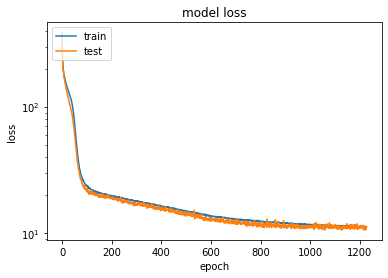

## MODEL SAVED ##


In [63]:
train_set = df_calendar.year.values <= 2018
test_set = df_calendar.year.values == 2019

input_cvae = [df_conso.values[train_set,:]] + [c[train_set,:] for c in condarray]
output_cvae = df_conso.values[train_set,:]

new_cae.train(input_cvae, epochs= 4000, verbose=0,
              batch_size=batch_size, callbacks=[earl_stop])

## Evaluer l'importance et la qualité des embeggings appris

Nous allons voir:
- l'importance portée par des variables dans la représentation latente
- l'importance portée par des variables dans l'embedding conditionnel

Nous nous appuyons pour cela sur des score d'information, de démêlement, de compacité et de modularité

Nous devrions constater que des variables importante dans l'embedding conditionnel ne le sont plus dans la représentation latente: elles ont été factorisées

In [64]:
x_encoded = new_cae.encoder.predict(input_cvae)[0]

Mutual Information Gap : 0.33


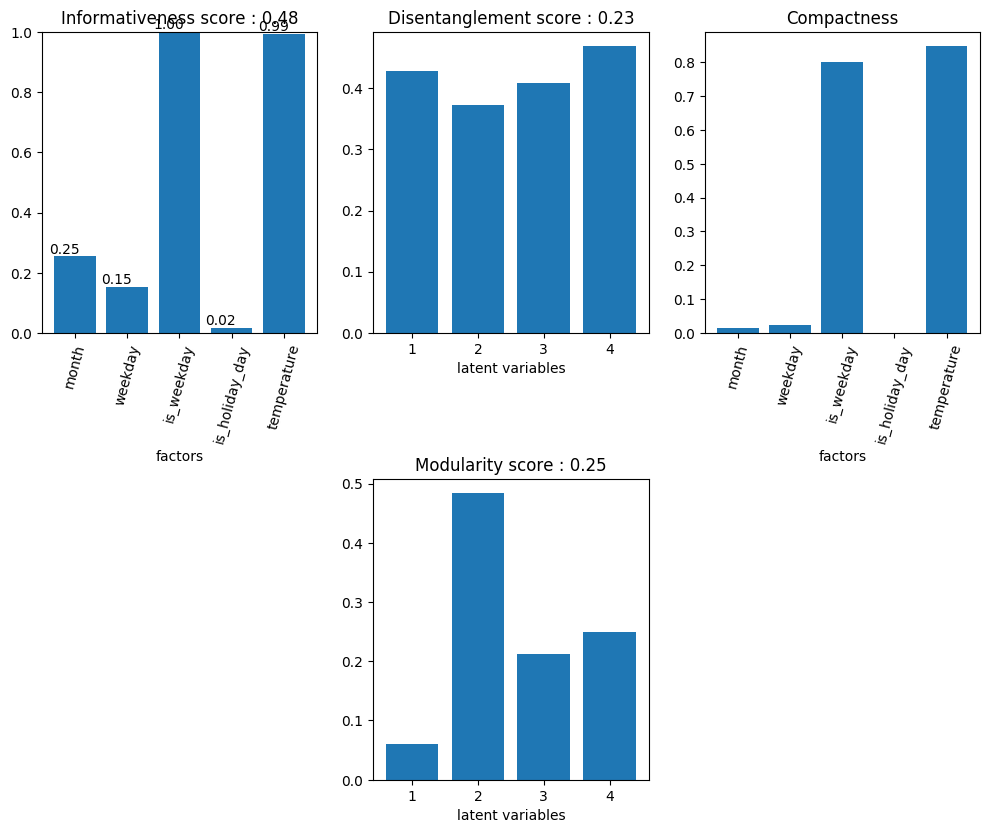

In [65]:
model_eval, importanceMatrix =evaluate_latent_code(x_encoded, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_evaluation_latent_code(model_eval, z_dim, factorDesc)

In [66]:
test_input_cvae = [df_conso.values[test_set,:]] + [c[test_set,:] for c in condarray]

x_hat = new_cae.model.predict(test_input_cvae)

np.mean(np.abs(x_hat - test_input_cvae[0]))

1.0136436886765414

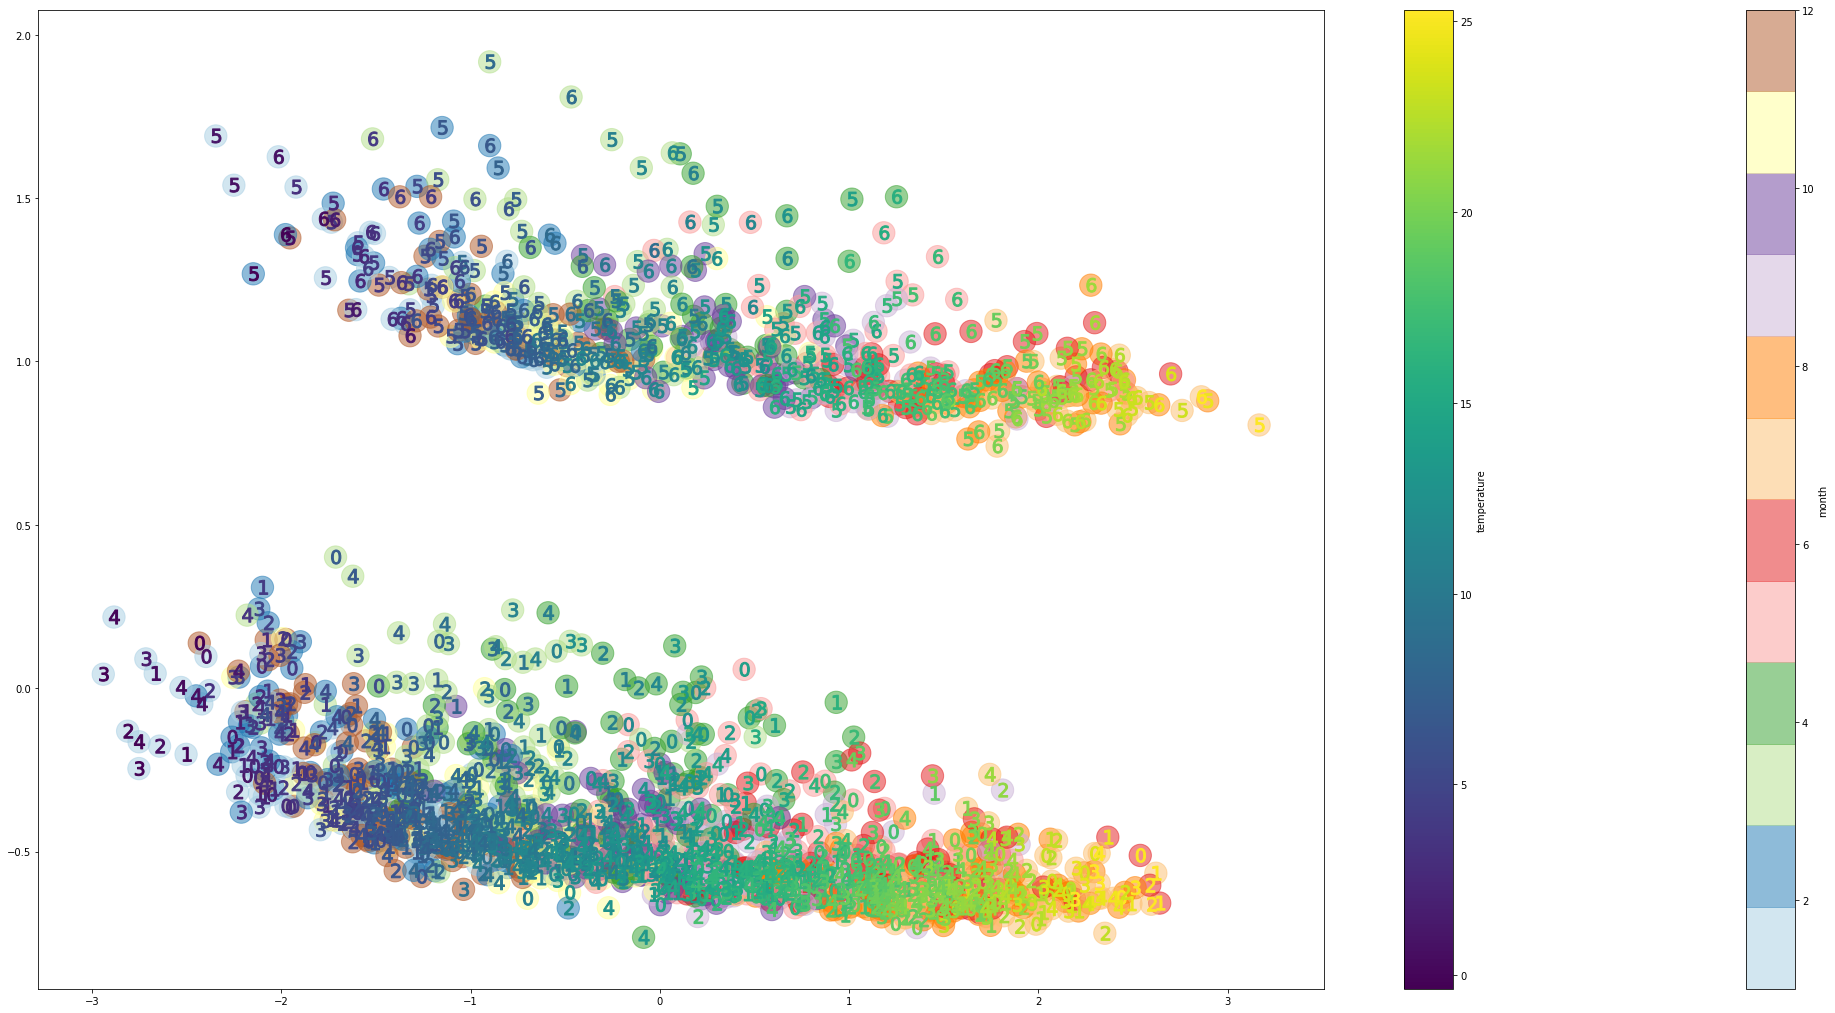

In [67]:
prez_2D(x_encoded, factorMatrix[train_set,:], temperatureMean[train_set])